# NEURAL NETWORK FROM SCRATCH

On this notebook I'm trying to create an artificial neural netowrk from scratch. Just using numpy for matrix operations since it is very optimized and without it the training would be very slow.
First import packages (tensorflow for the mnist dataset and the train_test split function from sklearn)

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import csv
import matplotlib.pyplot as plt
import sys
import tensorflow as tf

Custom function for a specific dataset with data from a website, trying to predict if the user buys a product or not based on data collected by the website.

In [3]:
def load_data_shopping(directory):
    with open(directory) as f:
        reader = csv.DictReader(f)

        evidence = []
        labels = []

        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

        for row in reader:
            row_evidence = [
                int(row["Administrative"]),
                float(row["Administrative_Duration"]),
                int(row["Informational"]),
                float(row["Informational_Duration"]),
                int(row["ProductRelated"]),
                float(row["ProductRelated_Duration"]),
                float(row["BounceRates"]),
                float(row["ExitRates"]),
                float(row["PageValues"]),
                float(row["SpecialDay"]),
                months.index(row["Month"]),
                int(row["OperatingSystems"]),
                int(row["Browser"]),
                int(row["Region"]),
                int(row["TrafficType"]),
                1 if row["VisitorType"] == "Returning_Visitor" else 0,
                1 if row["Weekend"] == "TRUE" else 0
            ]

            label = 1 if row["Revenue"] == "TRUE" else 0

            evidence.append(row_evidence)
            labels.append(label)

        return (evidence, labels)

## Definition of the functions

First we will define the functions that we will use for the main algorithm, starting with the initialization of the weights and biases. Depending on the data we will be using a large number of neurons per layer, so the initialization of the weights must be made having that in mind, since for large weight matrices, if the initialization results in lots of $w_{ij} \approx 0$ or $w_{ij} >>> 0$, it can cause numerical inconsistency and activations/gradients becoming too large (vanishing/exploding gradients). This is why the initialization used is the **He initialization**:
$$
W_{ij} \sim \mathcal{N}\left(0, \frac{2}{n_{neurons[i]}}\right)
$$

(For the biases it is safe to initialize them at 0)
We will store the weights in a list of numpy arrays, each numpy array will be the weights of a layer and it will have a $(n_{l+1}, n_{l})$ shape. For the biases we will do the same and their shape will be $(n_{l}, 1)$. Both will start at index 1 (0 in python, so w[0] corresponds to the first layer).

In [1]:
def initialize_params(layers: int, n_neurons: list):
    if len(n_neurons) != layers:
        return "Invalid number of neurons per layer."
    weights = []
    bias = []
    for i in range(layers - 1):
        W = np.random.randn(n_neurons[i + 1], n_neurons[i]) * np.sqrt(2. / n_neurons[i])
        b = np.zeros((n_neurons[i + 1], 1))
        weights.append(W)
        bias.append(b)
    return (weights, bias)

Now we define the **Sigmoid, ReLU** and **Softmax** functions (and their derivatives). For the **Sigmoid** and **ReLU**, their matrix derivatives apply individually on its entries since they asume independence between neurons on each layer:
$$
\sigma(z) = \frac{1}{1 + e^{-z}}, \quad \frac{d}{dz}\sigma(z) = \sigma(z) \cdot (1-\sigma(z))
$$

$$
\text{ReLU}(z) =  
\begin{cases}
z & \text{if } z > 0 \\
0 & \text{if } z \leq 0
\end{cases}, \quad 
\frac{d}{dz}\text{ReLU}(z) = 
\begin{cases}
1 & \text{if } z > 0 \\
0 & \text{if } z < 0 \\
\text{undefined} & \text{if } z = 0
\end{cases}
$$

$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}, \quad \text{for } i = 1, 2, \dots, K
$$

For the **Softmax** function, there exists dependence between the neurons on each layer (since it transforms it's activations into probability distributions), so the derivative isn't just a function applied individually on each element, it takes a different form. Since on the output layer we will always use **Softmax** and a **Cross-entropy** loss function, we won't need the derivative of the **Softmax**. We will explain this more in depth later.

In [2]:
def Sigmoid(z):
    return 1 / (1 + np.exp(-z))

def Sigmoid_derivative(z):
    s = Sigmoid(z)
    return s * (1 - s)

def ReLU(z):
    return np.maximum(0, z)

def ReLU_derivative(z):
    return (z > 0).astype(float)

def Softmax(z):
    max_z = np.max(z, axis=1, keepdims=True)
    ez = np.exp(z - max_z)
    
    sum_ez = np.sum(ez, axis=1, keepdims=True)
    return ez / sum_ez

For the forward function, it's use is to get an input through the whole network, keeping the $A$ and $Z$ values for each layer. These are obtained by computing the linear combination of the activation of the neurons of the last layer using the weights as parameters and the bias as an intercept. So, if $f^{(l)}$ is the activation funtion for the $l$-th layer:
$$
Z^{(1)} = X \cdot (W^{(1)})^T + (b^{(1)})^T \quad (m \text{x} n_1) \rightarrow a^{(1)} = f^{(1)}(Z^{(1)}) \quad (m \text{x} n_1) \\
Z^{(2)} = a^{(1)} \cdot (W^{(2)})^T + (b^{(2)})^T \quad (m \text{x} n_2) \rightarrow a^{(2)} = f^{(2)}(Z^{(2)}) \quad (m \text{x} n_2) \\
\vdots \\
Z^{(l)} = a^{(l-1)} \cdot (W^{(l)})^T + (b^{(l)})^T \quad (m \text{x} n_l) \rightarrow a^{(l)} = f^{(l)}(Z^{(l)}) \quad (m \text{x} n_l)\\
$$

Now in each $Z^{(l)}$ we have $m$ rows that correspond to each of the observations of the dataset (or current batch, since we will be implementing mini-batch gradient descent), and the values of the columns are the pre activation function values ($z^{(l)}_j$) of each neuron of the layer. The matrix $a^{(l)}$ is the same but applying the activation function $f^{(l)}$ to each element of the matrix.

In [3]:
def forward(X, weights, bias, functions):
    if len(functions) != len(weights):
        return "Invalid number of functions."
    A = []
    Z = []
    a = X
    for i in range(len(weights)):
        z = a.dot(weights[i].T) + bias[i].T
        #z = weights[i] @ X + bias[i]
        Z.append(z)
        f = functions[i]
        if f == "ReLU":
            a = ReLU(z)
        elif f == "Sigmoid":
            a = Sigmoid(z)
        elif f == "Softmax":
            a = Softmax(z)
        else:
            return "Specify activation function."
        A.append(a)
    return A, Z

Backpropagation is the method used on neural networks to update the weights and biases so we decrease the loss on the predictions of the training data set. The way it achieves this is using gradient descent and the chain rule. Gradient descent is an iterative method that find local minimums of a function by using the expression ($\alpha$ is the learning rate, decided by the researcher):
$$
W^{(l)} := W^{(l)} - \alpha \cdot \frac{\partial J}{\partial W^{(l)}} \\
b^{(l)} := b^{(l)} - \alpha \cdot \frac{\partial J}{\partial b^{(l)}}
$$

The function we want to minimize is the loss function, wich we will define as the sum of the losses of each observation respect to it's correct value (the label in the dataset):
$$
J = \frac{1}{m} \sum^m_{i=1} \mathcal{L}(a_{i.}^{(L)}, y_{i.})
$$

The problem with this function is that it doesn't have a closed form, so we can't calculate it's gradient for gradient descent. We solve this by using the chain rule:
$$
\frac{\partial J}{\partial W^{(L)}} = \frac{\partial J^{(L)}}{\partial a^{(L)}} \cdot \frac{\partial a^{(L)}}{\partial Z^{(L)}} \cdot \frac{\partial Z^{(L)}}{\partial W^{(L)}} \\
\frac{\partial J}{\partial b^{(L)}} = \frac{\partial J^{(L)}}{\partial a^{(L)}} \cdot \frac{\partial a^{(L)}}{\partial Z^{(L)}} \cdot \frac{\partial Z^{(L)}}{\partial b^{(L)}}
$$

Then we can define an error expression in common with both the weight and biases gradients:
$$
\delta^{(L)} = \frac{\partial J^{(L)}}{\partial a^{(L)}} \cdot \frac{\partial a^{(L)}}{\partial Z^{(L)}} = \frac{\partial J^{(L)}}{\partial a^{(L)}} \cdot f^{(2)'}(Z^{(2)})
$$

And since on the last layer we will be using the **Softmax** activation function (to obtain a probability distribution) and a **Cross-entropy** loss function, the error simplifies to:
$$
\delta^{(L)} = a^{(L)} - y
$$

Then we can calculate the gradients using the expression (we transpose the second term and change the order of the multiplication so the dimensions fit):
$$
\frac{\partial J}{\partial W^{(L)}} = 
$$

In [4]:
""" def backward(A, W, X, Z, y,  functions):
    n_layers = len(W) + 1
    gradients_w = []
    gradients_b = []
    
    # Start from output layer and move backwards
    for i in reversed(range(n_layers - 1)):
        if i == n_layers - 2:  # Output layer with softmax and cross-entropy loss
            dz = A[i] - y
        else:  # Hidden layers
            if functions[i] == "ReLU":
                dadz = ReLU_derivative(Z[i])
            elif functions[i] == "Sigmoid":
                dadz = Sigmoid_derivative(Z[i])
            else:
                return "Invalid activation function"
            
            dz = dz.dot(W[i + 1]) * dadz
        
        # Calculate gradients
        if i == 0:
            a_prev = X
        else:
            a_prev = A[i-1]
            
        dw = a_prev.T.dot(dz) / len(y)
        db = np.mean(dz, axis=0, keepdims=True)
        
        gradients_w.insert(0, dw)
        gradients_b.insert(0, db)
    
    return gradients_w, gradients_b """

def backward(A, W, X, Z, y, functions):
    m = y.shape[0]
    gradients_w = [0] * len(W)
    gradients_b = [0] * len(W)

    dz = A[-1] - y
    for i in reversed(range(len(W))):
        a_prev = X if i == 0 else A[i-1]
        gradients_w[i] = (dz.T @ a_prev) / m
        gradients_b[i] = np.mean(dz, axis=0, keepdims=True).T
        
        if i > 0:
            if functions[i-1] == "ReLU":
                dz = (dz @ W[i]) * ReLU_derivative(Z[i-1])
            elif functions[i-1] == "Sigmoid":
                dz = (dz @ W[i]) * Sigmoid_derivative(Z[i-1])
            else:
                raise ValueError("Función de activación inválida")
                
    return gradients_w, gradients_b


In [5]:
""" def update_params(W, b, grads_w, grads_b, alpha):
    for i in range(len(W)):
        W[i] = W[i] - alpha*grads_w[i].T
        b[i] = b[i] - alpha*grads_b[i].T
    return W, b """

def update_params(W, b, grads_w, grads_b, alpha):
    for i in range(len(W)):
        W[i] = W[i] - alpha*grads_w[i]
        b[i] = b[i] - alpha*grads_b[i]
    return W, b

def get_predictions(a):
    return np.argmax(a, axis=1)

def get_accuracy(predictions, y):
    return np.mean(predictions == y)

def standardize(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

def create_mini_batches(X, y, batch_size):
    m = X.shape[0]
    # Barajar índices
    permutation = np.random.permutation(m)
    X_shuffled = X[permutation]
    y_shuffled = y[permutation]
    
    mini_batches = []
    num_batches = m // batch_size
    
    for i in range(num_batches):
        X_batch = X_shuffled[i*batch_size:(i+1)*batch_size]
        y_batch = y_shuffled[i*batch_size:(i+1)*batch_size]
        mini_batches.append((X_batch, y_batch))
    
    # Resto (si m % batch_size != 0)
    if m % batch_size != 0:
        X_batch = X_shuffled[num_batches*batch_size:]
        y_batch = y_shuffled[num_batches*batch_size:]
        mini_batches.append((X_batch, y_batch))
    
    return mini_batches

def mini_batch(X, y, size):
    random_indexes = np.random.choice(X.shape[0], size=size, replace=False)
    return (X[random_indexes, :], y[random_indexes])

In [6]:
def make_predictions(X_train, weights, bias, functions):
    A, _ = forward(X_train, weights, bias, functions)
    predictions = get_predictions(A[-1])
    return predictions

def test_prediction(X_train, Y_train, index, weights, bias, functions):
    current_image = X_train[index]
    prediction = make_predictions(X_train[None, :], weights, bias, functions)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()


In [7]:
evidence, labels = load_data_shopping("shopping.csv")
X_train, X_test, y_train, y_test = train_test_split(
    evidence, labels, test_size=0.4
)

X_test = np.array(X_test)
Y_test = y_test
Y = np.array(y_train)
y = np.eye(2)[y_train]
X = standardize(np.array(X_train))

""" X = np.array([
    [0.5, 1.2, 0.8],
    [1.5, 0.3, 1.0],
    [0.4, 1.5, 0.7]
])
Y = np.array([0, 1, 0])
y = np.eye(2)[Y] """

#define network
EPOCHS = 500
alpha = 0.01
layers = 3
batch_size = 20
n_neurons = [len(X[0]), 10, 2]
functions = ["Sigmoid", "Softmax"]

weights, bias = initialize_params(layers, n_neurons)

""" while epochs > 0:
    A, Z = forward(X, weights, bias, functions)
    gradients_w, gradients_b = backward(A, weights, X, Z, y, functions)
    weights, bias = update_params(weights, bias, gradients_w, gradients_b, alpha)
    if epochs % 50 == 0:
        print("Epoch: ", ITERATIONS - epochs)
        print("Train Accuracy: ", get_accuracy(get_predictions(A[-1]), Y))
        A_test = forward(X_test, weights, bias, functions)[0]
        print("Test Accuracy: ", get_accuracy(get_predictions(A_test[-1]), Y_test))
    epochs -= 1
print("Epoch: ", ITERATIONS - epochs)
print("Train Accuracy: ", get_accuracy(get_predictions(A[-1]), Y))
A_test = forward(X_test, weights, bias, functions)[0]
print("Test Accuracy: ", get_accuracy(get_predictions(A_test[-1]), Y_test)) """

train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(EPOCHS):
    mini_batches = create_mini_batches(X, Y, batch_size)
    for X_mb, Y_mb in mini_batches:
        y_mb = np.eye(2)[Y_mb]
        A, Z = forward(X_mb, weights, bias, functions)
        gradients_w, gradients_b = backward(A, weights, X_mb, Z, y_mb, functions)
        weights, bias = update_params(weights, bias, gradients_w, gradients_b, alpha)
    if epoch % 10 == 0 or epoch == EPOCHS - 1:
        print("Epoch: ", epoch)
        epoch_list.append(epoch)
        A_acc, Z_acc = forward(X, weights, bias, functions)
        train_acc = get_accuracy(get_predictions(A_acc[-1]), Y)
        train_acc_list.append(train_acc)
        print("Train Accuracy: ", train_acc)
        A_test = forward(X_test, weights, bias, functions)[0]
        test_acc = get_accuracy(get_predictions(A_test[-1]), Y_test)
        test_acc_list.append(test_acc)
        print("Test Accuracy: ", test_acc)

NameError: name 'load_data_shopping' is not defined

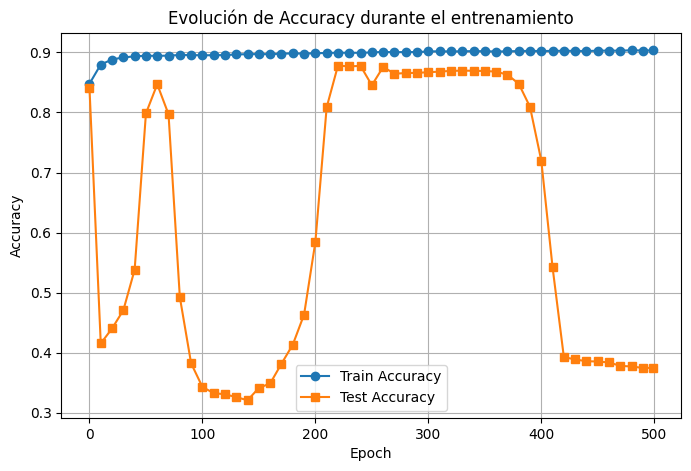

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(epoch_list, train_acc_list, label="Train Accuracy", marker='o')
plt.plot(epoch_list, test_acc_list, label="Test Accuracy", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evolución de Accuracy durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Cambiar forma de (n_samples, 28, 28) → (n_samples, 784)
X_train = X_train.reshape(X_train.shape[0], 28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)

Y_test = y_test
Y = y_train
y = np.eye(10)[y_train]
X = X_train / 255.
X_test = X_test / 255.

############## define network ##############
alpha = 0.01
EPOCHS = 200
layers = 3
batch_size = 1000
n_neurons = [len(X[0]), 128, 10]
functions = ["ReLU", "Softmax"]
############################################

weights, bias = initialize_params(layers, n_neurons)

train_acc_list = []
test_acc_list = []
epoch_list = []

for epoch in range(EPOCHS):
    mini_batches = create_mini_batches(X, Y, batch_size)
    for X_mb, Y_mb in mini_batches:
        y_mb = np.eye(10)[Y_mb]
        A, Z = forward(X_mb, weights, bias, functions)
        gradients_w, gradients_b = backward(A, weights, X_mb, Z, y_mb, functions)
        weights, bias = update_params(weights, bias, gradients_w, gradients_b, alpha)
    if epoch % 10 == 0 or epoch == EPOCHS - 1:
        print("Epoch: ", epoch)
        epoch_list.append(epoch)
        A_acc, Z_acc = forward(X, weights, bias, functions)
        train_acc = get_accuracy(get_predictions(A_acc[-1]), Y)
        train_acc_list.append(train_acc)
        print("Train Accuracy: ", train_acc)
        A_test = forward(X_test, weights, bias, functions)[0]
        test_acc = get_accuracy(get_predictions(A_test[-1]), Y_test)
        test_acc_list.append(test_acc)
        print("Test Accuracy: ", test_acc)

Epoch:  0
Train Accuracy:  0.5278333333333334
Test Accuracy:  0.5352
Epoch:  10
Train Accuracy:  0.8592
Test Accuracy:  0.8652
Epoch:  20
Train Accuracy:  0.88455
Test Accuracy:  0.8916
Epoch:  30
Train Accuracy:  0.8959166666666667
Test Accuracy:  0.9035
Epoch:  40
Train Accuracy:  0.9037333333333334
Test Accuracy:  0.9103
Epoch:  50
Train Accuracy:  0.9091
Test Accuracy:  0.916
Epoch:  60
Train Accuracy:  0.9141166666666667
Test Accuracy:  0.9196
Epoch:  70
Train Accuracy:  0.91815
Test Accuracy:  0.9228
Epoch:  80
Train Accuracy:  0.9215333333333333
Test Accuracy:  0.9244
Epoch:  90
Train Accuracy:  0.9243333333333333
Test Accuracy:  0.9271
Epoch:  100
Train Accuracy:  0.9272166666666667
Test Accuracy:  0.9296
Epoch:  110
Train Accuracy:  0.9292833333333334
Test Accuracy:  0.9314
Epoch:  120
Train Accuracy:  0.9316166666666666
Test Accuracy:  0.9341
Epoch:  130
Train Accuracy:  0.9336166666666667
Test Accuracy:  0.9352
Epoch:  140
Train Accuracy:  0.9354666666666667
Test Accuracy:  

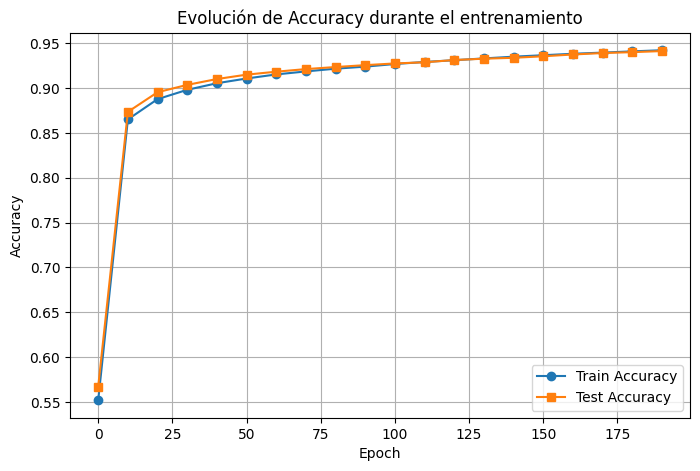

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(epoch_list, train_acc_list, label="Train Accuracy", marker='o')
plt.plot(epoch_list, test_acc_list, label="Test Accuracy", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evolución de Accuracy durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def make_predictions(X_train, weights, bias, functions):
    A, _ = forward(X_train, weights, bias, functions)
    predictions = get_predictions(A[-1])
    return predictions

def test_prediction(X_train, Y_train, index, weights, bias, functions):
    current_image = X_train[index]
    prediction = make_predictions(X_train, weights, bias, functions)[index]
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()


Prediction:  7
Label:  7


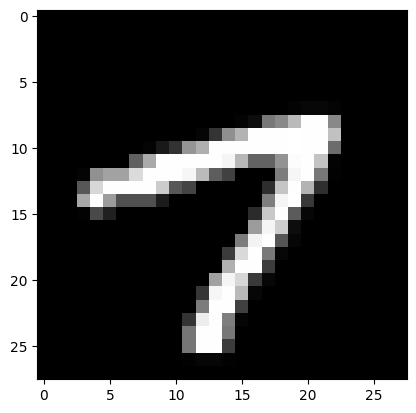

' A_acc, Z_acc = forward(X, weights, bias, functions)\nget_predictions(A_acc[-1]) '

In [ ]:
test_prediction(X, Y, 101, weights, bias, functions)
""" A_acc, Z_acc = forward(X, weights, bias, functions)
get_predictions(A_acc[-1]) """